/home/zhemin/ENTER/envs/llama/lib/python3.11/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


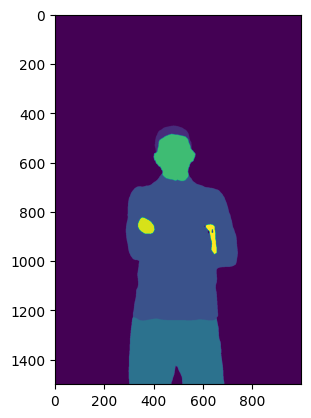

In [2]:
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch.nn as nn

# processor = SegformerImageProcessor.from_pretrained("/Users/hellozhems/Documents/Models/mattmdjaga/segformer_b2_clothes")
# model = AutoModelForSemanticSegmentation.from_pretrained("/Users/hellozhems/Documents/Models/mattmdjaga/segformer_b2_clothes")

processor = SegformerImageProcessor.from_pretrained("/home/zhemin/Documents/models/mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("/home/zhemin/Documents/models/mattmdjaga/segformer_b2_clothes")

url = "https://plus.unsplash.com/premium_photo-1673210886161-bfcc40f54d1f?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8cGVyc29uJTIwc3RhbmRpbmd8ZW58MHx8MHx8&w=1000&q=80"

image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]
plt.imshow(pred_seg)

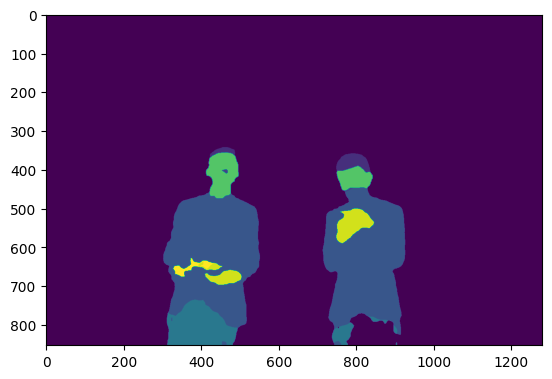

In [4]:
image = Image.open('images/4.jpg')
inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]
plt.imshow(pred_seg)

In [5]:
model.config.id2label

{0: 'Background',
 1: 'Hat',
 2: 'Hair',
 3: 'Sunglasses',
 4: 'Upper-clothes',
 5: 'Skirt',
 6: 'Pants',
 7: 'Dress',
 8: 'Belt',
 9: 'Left-shoe',
 10: 'Right-shoe',
 11: 'Face',
 12: 'Left-leg',
 13: 'Right-leg',
 14: 'Left-arm',
 15: 'Right-arm',
 16: 'Bag',
 17: 'Scarf'}

In [8]:
no_to_part = model.config.id2label
part_to_no = {v: k for k, v in no_to_part.items()}

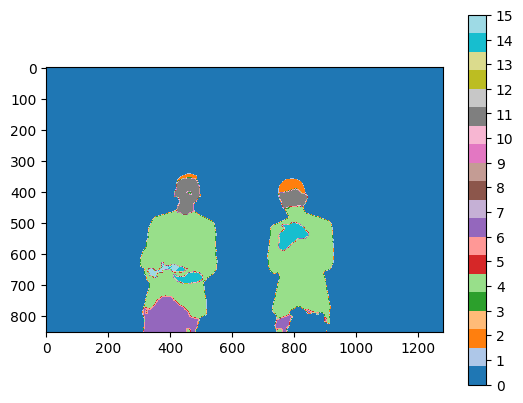

0 [Background]: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
1 [Hat]: (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)
2 [Hair]: (1.0, 0.4980392156862745, 0.054901960784313725)
3 [Sunglasses]: (1.0, 0.7333333333333333, 0.47058823529411764)
4 [Upper-clothes]: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
5 [Skirt]: (0.596078431372549, 0.8745098039215686, 0.5411764705882353)
6 [Pants]: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
7 [Dress]: (1.0, 0.596078431372549, 0.5882352941176471)
8 [Belt]: (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
9 [Left-shoe]: (0.7725490196078432, 0.6901960784313725, 0.8352941176470589)
10 [Right-shoe]: (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
11 [Face]: (0.7686274509803922, 0.611764705882353, 0.5803921568627451)
12 [Left-leg]: (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
13 [Right-leg]: (0.9686274509803922, 0.7137254901960784, 0.8235294117647058)

In [7]:
import matplotlib as mpl
label_names = list(model.config.id2label)
# Create a color map with the same number of colors as your labels
# Use the updated method to get the colormap
cmap = mpl.colormaps['tab20']

# Create the figure and axes for the plot and the colorbar
fig, ax = plt.subplots()

# Display the segmentation
im = ax.imshow(pred_seg, cmap=cmap)

# Create a colorbar
cbar = fig.colorbar(im, ax=ax, ticks=range(len(label_names)))
cbar.ax.set_yticklabels(label_names)

plt.show()

# Get the number of labels
n_labels = len(label_names)

# Extract RGB values for each color in the colormap
colors = cmap.colors[:n_labels]

# Convert RGBA to RGB by omitting the Alpha value
rgb_colors = [color[:3] for color in colors]

# Create a dictionary mapping labels to RGB colors
label_to_color = dict(zip(label_names, rgb_colors))

# Display the mapping
for label, color in label_to_color.items():
    print(f"{label} [{model.config.id2label[label]}]: {color}")

In [1]:
import torch
from diffusers import AutoPipelineForInpainting, LCMScheduler
from diffusers.utils import load_image, make_image_grid

pipe = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16,
    variant="fp16",
).to("cuda")

# set scheduler
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)

# load LCM-LoRA
pipe.load_lora_weights("/home/zhemin/Documents/models/latent-consistency/lcm-lora-sdxl")
pipe.fuse_lora()

# load base and mask image
init_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint.png").resize((1024, 1024))
mask_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint_mask.png").resize((1024, 1024))

prompt = "a castle on top of a mountain, highly detailed, 8k"
generator = torch.manual_seed(42)
image = pipe(
    prompt=prompt,
    image=init_image,
    mask_image=mask_image,
    generator=generator,
    num_inference_steps=5,
    guidance_scale=4,
).images[0]
make_image_grid([init_image, mask_image, image], rows=1, cols=3)


Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]